In [1]:
from mitoolspro.regressions import linear_models
import numpy as np
from pandas import DataFrame
import statsmodels.api as sm
from mitoolspro.plotting import LinePlotter, ScatterPlotter, PlotComposer

# Quantile Regression from Statsmodels

https://www.statsmodels.org/stable/examples/notebooks/generated/quantile_regression.html

In [2]:
data = sm.datasets.engel.load_pandas().data
data.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


## Least Absolute Deviation

The LAD model is a special case of quantile regression where q=0.5



In [3]:
model = linear_models.QuantileRegressionModel(data=data, formula="foodexp ~ income", quantiles=0.5)
res = model.fit()
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Wed, 19 Mar 2025   No. Observations:                  235
Time:                        21:28:51   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


## Visualizing the results

We estimate the quantile regression model for many quantiles between .05 and .95, and compare best fit line from each of these models to Ordinary Least Squares results.

#### Prepare data for plotting

For convenience, we place the quantile regression results in a Pandas DataFrame, and the OLS results in a dictionary.

In [4]:
quantiles = np.arange(0.05, 0.96, 0.1)
model = linear_models.QuantileRegressionModel(data=data, formula="foodexp ~ income", quantiles=quantiles)
ols = model.fit()

models = DataFrame([[q, res.params['Intercept'], res.params['income']] + res.conf_int().loc['income'].tolist() for q, res in ols.items()])
models.columns = ['q', 'a', 'b', 'lb', 'ub']

In [5]:
ols = linear_models.OLSModel(data=data, formula="foodexp ~ income")
ols = ols.fit()
ols_ci = ols.conf_int().loc["income"].tolist()
ols = dict(
    a=ols.params["Intercept"], b=ols.params["income"], lb=ols_ci[0], ub=ols_ci[1]
)

In [6]:
print(models)
print(ols)

      q           a         b        lb        ub
0  0.05  124.880096  0.343361  0.268632  0.418090
1  0.15  111.693660  0.423708  0.382780  0.464636
2  0.25   95.483539  0.474103  0.439900  0.508306
3  0.35  105.841294  0.488901  0.457759  0.520043
4  0.45   81.083647  0.552428  0.525021  0.579835
5  0.55   89.661370  0.565601  0.540955  0.590247
6  0.65   74.033434  0.604576  0.582169  0.626982
7  0.75   62.396584  0.644014  0.622411  0.665617
8  0.85   52.272216  0.677603  0.657383  0.697823
9  0.95   64.103964  0.709069  0.687831  0.730306
{'a': np.float64(147.47538852370556), 'b': np.float64(0.48517842367692354), 'lb': 0.4568738130184233, 'ub': 0.5134830343354237}


#### First plot

This plot compares best fit lines for 10 quantile regression models to the least squares fit. As Koenker and Hallock (2001) point out, we see that:

1. Food expenditure increases with income
2. The dispersion of food expenditure increases with income
3. The least squares estimates fit low income observations quite poorly (i.e. the OLS line passes over most low income households)

In [7]:
x = np.arange(data.income.min(), data.income.max(), 50)
def get_y(a, b):
    return a + b * x

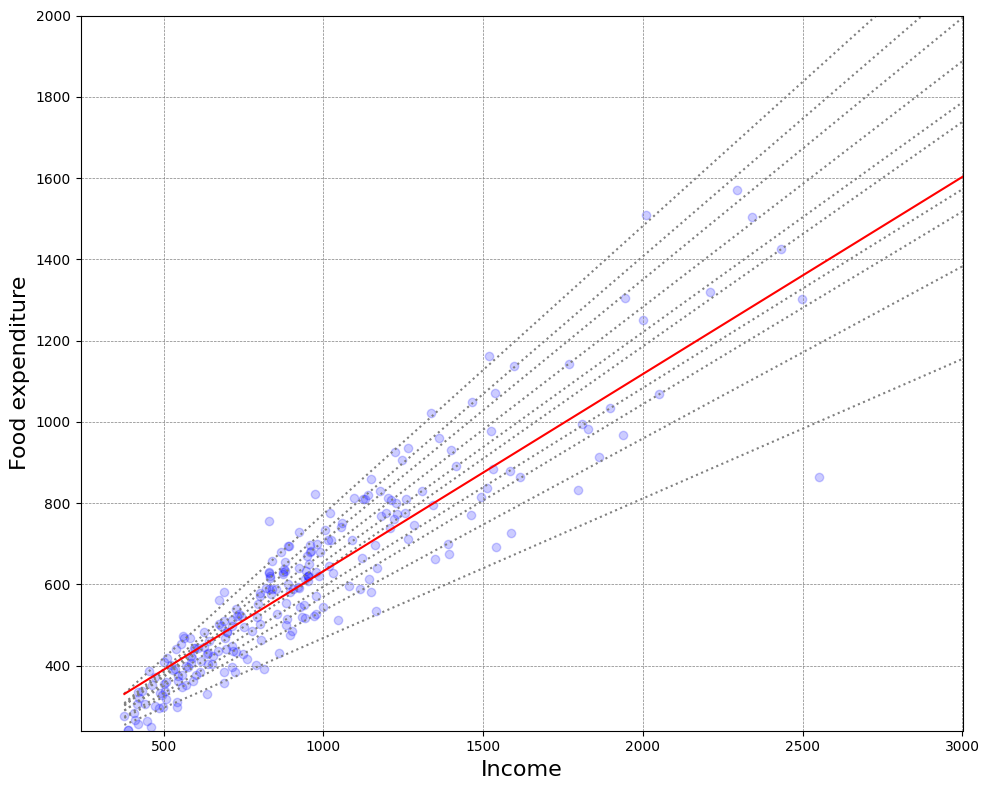

In [8]:
y = get_y(ols["a"], ols["b"])
plot = PlotComposer([
    LinePlotter([x]*models.shape[0], [get_y(models.a[i], models.b[i]) for i in range(models.shape[0])])
    .set_linestyle("dotted")
    .set_color('grey'),
    LinePlotter(x, y, color='red', label='OLS')
    .set_marker(""),
    ScatterPlotter(data.income, data.foodexp, color='blue', label='Data', alpha=0.2)
    .set_limits((240, 3000), (240, 2000))
    .set_xlabel("Income", fontsize=16)
    .set_ylabel("Food expenditure", fontsize=16)
],
style=None,
grid={"visible": True, "color": "grey", "linestyle": "--", "linewidth": 0.5},
tight_layout=True,
)
ax = plot.draw()

#### Second plot

The dotted black lines form 95% point-wise confidence band around 10 quantile regression estimates (solid black line). The red lines represent OLS regression results along with their 95% confidence interval.

In most cases, the quantile regression point estimates lie outside the OLS confidence interval, which suggests that the effect of income on food expenditure may not be constant across the distribution.

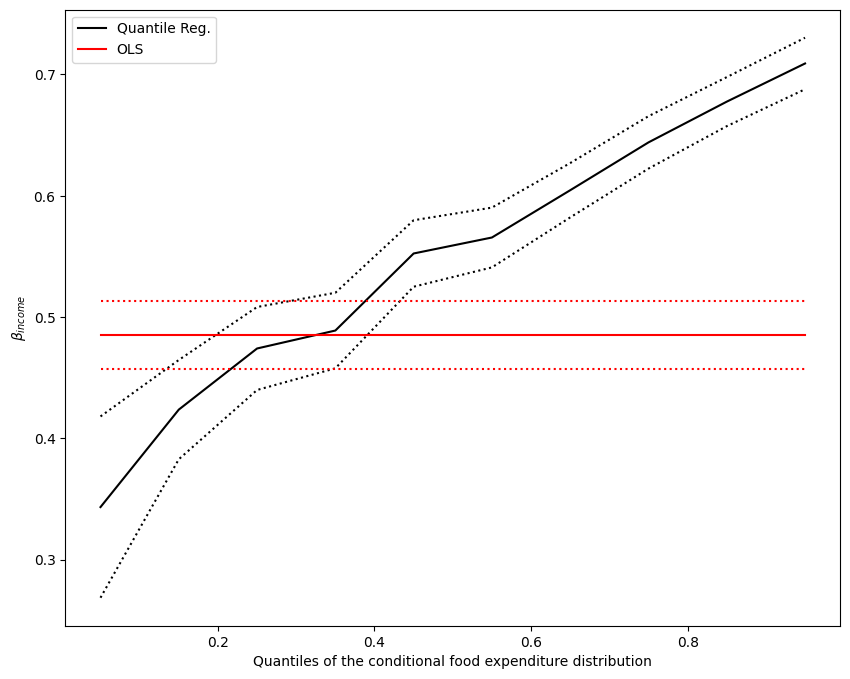

In [9]:
n = models.shape[0]
ax = PlotComposer([
    LinePlotter(models.q, models.b, color="black", label="Quantile Reg."),
    LinePlotter(models.q, models.ub, linestyle="dotted", color="black"),
    LinePlotter(models.q, models.lb, linestyle="dotted", color="black"),
    LinePlotter(models.q, [ols["b"]] * n, color="red", label="OLS"),
    LinePlotter(models.q, [ols["lb"]] * n, linestyle="dotted", color="red"),
    LinePlotter(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
    .set_ylabel(r"$\beta_{income}$")
    .set_xlabel("Quantiles of the conditional food expenditure distribution")
]).draw()
_ = ax.legend()

***